In [225]:
import ipynb.fs.full.preProcessing as preProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
import seaborn as sns

DECISION TREE MODEL:

Models: DecisionTreeRegressor, AdaBoostRegressor, RandomForestRegressor
```
DEPTH = 5
models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=100, max_depth=DEPTH)
}
```

Output: Offence rate at time t (t in 2015, 2016 due to limited communities data)
Assumptions: The communities.csv contains the data for 2014, 2015 (assume constant across the span of 2-3 years)
Features input: 
1. All features from communities (with 2 extra features for distance) at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
2. Only the top 20 features from communities with the highest NMI with offence rate at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
3. Use 1. with PCA on all communities feature
4. Use 2. with PCA on all communities feature

Evaluation: 50 folds validation, and take the median of RMSE/ MSE

Results: Noted below

Conclusion:
For both features set, only adaboost performs better than re-use the offence rate at (t-1).
Features set 2 results in a lower RMSE for adaboost and random forest.

MODEL SET 2:
Change the output to the offence rate difference (or ratio), since it's what we should focus on.
Null model (Take the mean of the train set): Outperform the tree, since the tree stop
considering the last offence rate as an important determinant
=> The last offence rate is the main performance booster for the tree

Result:
```
For features 1:
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 697426.027159028
RMSE of regressor : 835.120329157219
MSE of ada : 383065.340033446
RMSE of ada : 618.9163007242792
MSE of rf : 570348.7403033725
RMSE of rf : 755.1780375340123
```
For features 2:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 687015.5763979282
RMSE of regressor : 828.81992487444
MSE of ada : 373469.0699750013
RMSE of ada : 611.1193833613015
MSE of rf : 515237.70031876455
RMSE of rf : 717.6376753858078
```

For feature 3:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 842206.1779428092
RMSE of regressor : 917.6453167869898
MSE of ada : 406525.1654475378
RMSE of ada : 637.5728913206328
MSE of rf : 549143.0549892331
RMSE of rf : 741.0413152627207
MSE of gradBoost : 548636.7169944311
RMSE of gradBoost : 740.6272149355789
MSE of linear : 502306.9062239253
RMSE of linear : 708.7361326937958
```

For feature 4:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 687015.5763979295
RMSE of regressor : 828.8199248744409
MSE of ada : 345211.10021193756
RMSE of ada : 587.5434376201954
MSE of rf : 549651.2250462435
RMSE of rf : 741.3667120304194
MSE of gradBoost : 530883.5605228033
RMSE of gradBoost : 728.4829348116281
MSE of linear : 502379.2913162628
RMSE of linear : 708.7871938301332
```

In [226]:
# Preparing the frame for training model
offences = preProcess.cleanedOffences
offences = offences.drop(columns=["Year ending", "Offence Count"])

communities = preProcess.cleanedCommunities
communities["Distance from Melbourne"] = np.sqrt(communities["Location_x"]**2 + communities["Location_y"]**2)
communities["Direction from Melbourne"] = np.arctan(communities["Location_x"]/ communities["Location_y"])

housingPrices = preProcess.cleanedHousingPrice
egm = preProcess.cleanedEgm


In [227]:
from sklearn.preprocessing import OneHotEncoder

modelData = offences[(offences["Year"] == 2015) | (offences["Year"] == 2016)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    modelData.loc[idx, "Last Offence Rate"] = offences[(offences["LGA"] == row["LGA"]) 
                                            & (offences["Year"] == row["Year"] - 1)]["Rate per 100,000 population"].iloc[0]
    modelData.loc[idx, "Last Housing Price"] = housingPrices.loc[row["LGA"]][str(row["Year"] - 1)]
    modelData.loc[idx, "Last EGM"] = egm.loc[row["LGA"]][str(row["Year"] - 1)]


In [228]:
# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
renameCol = {}
for column in oneHotLGA.columns:
    renameCol[column] = "LGA" + str(column)
oneHotLGA = oneHotLGA.rename(columns=renameCol)
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

# One hot the region
oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["Police Region"]).reshape(-1, 1))
oneHotRegion = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["Police Region"]).reshape(-1, 1))
                         .toarray())
renameCol = {}
for column in oneHotRegion.columns:
    renameCol[column] = "Region" + str(column)
oneHotRegion = oneHotRegion.rename(columns=renameCol)
modelData = modelData.join(oneHotRegion)
modelData = modelData.drop(columns=["Police Region"])

modelData

,Year,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),ARIA+ (avg),Commercial (km^2),Industrial (km^2),Residential (km^2),...,LGA50,LGA51,LGA52,LGA53,LGA54,LGA55,Region0,Region1,Region2,Region3
0,2016,7903.7,20.289781,84.535123,0.000000,0.000000,0.000000,0.008991,0.021552,0.605656,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2016,9375.1,19.419507,128.349256,0.000000,0.000000,0.000000,0.016543,0.213052,0.474939,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2016,10864.1,14.544640,45.693749,0.000000,0.000000,0.000000,0.029054,0.067348,0.697212,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2016,7166.8,16.202194,65.887204,0.000000,0.000000,0.000000,0.010994,0.107162,0.366402,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2016,11420.0,23.587200,599.996103,0.023828,0.037001,0.029642,0.016390,0.026318,0.094048,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2015,11385.6,384.960766,23359.313312,2.687931,3.482185,3.087847,0.000074,0.000461,0.001773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108,2015,6857.1,58.368445,2142.863230,0.331739,0.880712,0.598316,0.000394,0.002019,0.020584,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
109,2015,9876.3,179.410340,6720.196354,2.135649,2.837918,2.452597,0.000128,0.000423,0.002905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110,2015,5198.3,94.497165,1652.413568,0.512327,0.704602,0.606605,0.000191,0.000432,0.016410,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [229]:
from sklearn.decomposition import PCA
def getPCA(X_train, X_test):
    sklearn_pca = PCA(n_components=1)
    features_pca = sklearn_pca.fit(X_train)
    X_train["pca"] = features_pca.transform(X_train)
    X_test["pca"] = features_pca.transform(X_test)

FEATURES 1

In [230]:
# Define models here
# Models: https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/
# AdaBoost model (TODO: Recheck source): Train an initial tree with uniform weight for all points.
# Then, for subsequent iterations, change the weights so more weights are given for
# the points with errors.
# Then, random selection based on the normalized probability weights for the data points
# to construct a new datasets => Train a new tree on top of it 
# At the end, with 300 iterations, around 300 decision trees are built and used for regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

DEPTH = 5

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=300, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=300, max_depth=DEPTH),
    "gradBoost": GradientBoostingRegressor(n_estimators = 500,
        max_depth = DEPTH,
        min_samples_split = 3,
        learning_rate = 0.01,
        loss = "squared_error"),
    "linear": LinearRegression()
}

In [231]:
def getSplitAttributes(tree_rules: str):
    # Parsing the split attributes
    splitAtts = []
    AttRegex = r".*\|--- ([^<>=]*) [<>=].*"

    for line in tree_rules.split("\n"):
        # print(line)
        matchObj = re.match(AttRegex, line)
        if matchObj:
            att = matchObj.group(1)
            splitAtts.append(att)
            # print(att)
    return splitAtts

RMSE null:  4424.3710330399135
RMSE null 2:  968.6797054066254
RMSE of  regressor : 827.0896969461828
RMSE of  ada : 906.9789759326985
RMSE of  rf : 1133.1975423138274
RMSE of  gradBoost : 863.2839744981462
RMSE of  linear : 883.1231330016427


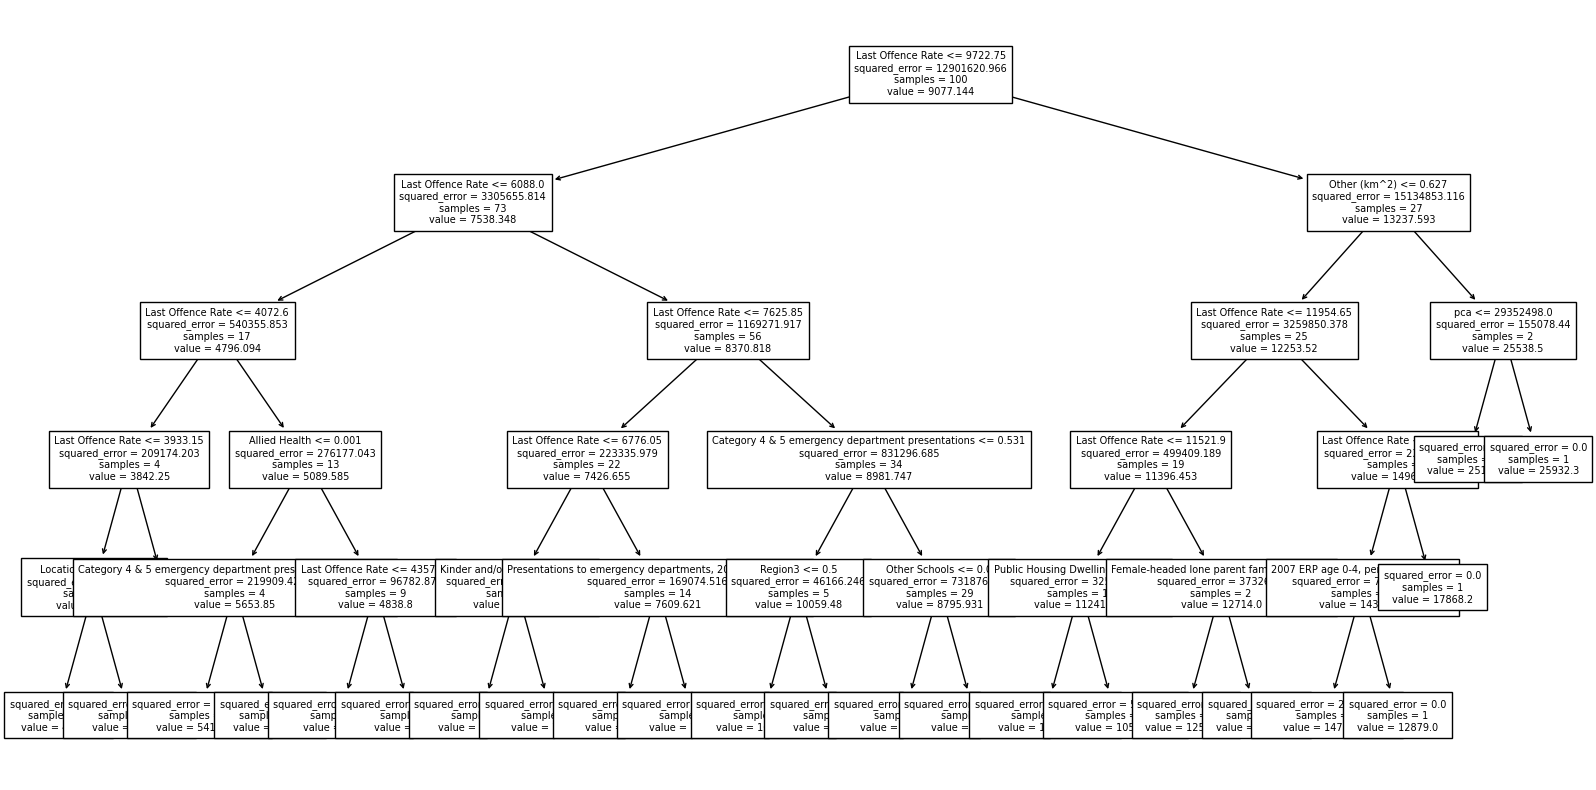

|--- Last Offence Rate <= 9722.75
|   |--- Last Offence Rate <= 6088.00
|   |   |--- Last Offence Rate <= 4072.60
|   |   |   |--- Last Offence Rate <= 3933.15
|   |   |   |   |--- Location_x <= 14.83
|   |   |   |   |   |--- value: [4267.20]
|   |   |   |   |--- Location_x >  14.83
|   |   |   |   |   |--- value: [4012.50]
|   |   |   |--- Last Offence Rate >  3933.15
|   |   |   |   |--- value: [3076.80]
|   |   |--- Last Offence Rate >  4072.60
|   |   |   |--- Allied Health <= 0.00
|   |   |   |   |--- Category 4 & 5 emergency department presentations <= 0.53
|   |   |   |   |   |--- value: [5412.67]
|   |   |   |   |--- Category 4 & 5 emergency department presentations >  0.53
|   |   |   |   |   |--- value: [6377.40]
|   |   |   |--- Allied Health >  0.00
|   |   |   |   |--- Last Offence Rate <= 4357.45
|   |   |   |   |   |--- value: [4617.20]
|   |   |   |   |--- Last Offence Rate >  4357.45
|   |   |   |   |   |--- value: [4949.60]
|   |--- Last Offence Rate >  6088.00
|   | 

In [232]:
# Use hold out for now
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = modelData.drop(columns=["Rate per 100,000 population", "Year"])
y = modelData["Rate per 100,000 population"] 
# y = (modelData["Rate per 100,000 population"] - modelData["Last Offence Rate"])

# 19 random state yields some odd precision, likely due to how the split is constructed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=100)
getPCA(X_train, X_test)

predicts = {}

for name in models:
    model = models[name]
    models[name] = model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    predicts[name] = y_predict


y_null_predict = [y_train.mean()] * len(X_test)

mse_null = mean_squared_error(y_test, y_null_predict)
modelTest = modelData.loc[X_test.index]
mse_null_2 = mean_squared_error(modelTest["Rate per 100,000 population"], modelTest["Last Offence Rate"])
print("RMSE null: ", np.sqrt(mse_null))
print("RMSE null 2: ", np.sqrt(mse_null_2))


for name in models:
    rmse = np.sqrt(mean_squared_error(predicts[name], y_test))
    print("RMSE of ", name, ":", rmse)



# Check the decision tree regressor
fig, axe = plt.subplots(figsize=(20,10))
plot_tree(models["regressor"], 
          feature_names=X_train.columns,
          ax=axe, 
          fontsize=7)
plt.show()

# Use text
tree_rules = export_text(models["regressor"], feature_names=list(X_train))
print(tree_rules)

print("Concise list of attributes")
print(pd.Series(getSplitAttributes(tree_rules)).value_counts())



C:\Users\DELL\AppData\Local\Temp\ipykernel_24512\2472727201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["pca"] = features_pca.transform(X_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_24512\2472727201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
C:\Users\DELL\AppData\Local\Temp\ipykernel_24512\2472727201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 842206.1779428092
RMSE of regressor : 917.6453167869898
MSE of ada : 406525.1654475378
RMSE of ada : 637.5728913206328
MSE of rf : 549143.0549892331
RMSE of rf : 741.0413152627207
MSE of gradBoost : 548636.7169944311
RMSE of gradBoost : 740.6272149355789
MSE of linear : 502306.9062239253
RMSE of linear : 708.7361326937958
Used attributes for regressor tree: 
Last Offence Rate                                       1230
Public Housing Dwellings                                  94
Public Hospitals                                          82
Last EGM                                                  80
Distance from Melbourne                                   78
                                                        ... 
Speaks LOTE at home, persons                               2
2012 ERP age 45-64, persons                                2

<Figure size 640x480 with 0 Axes>

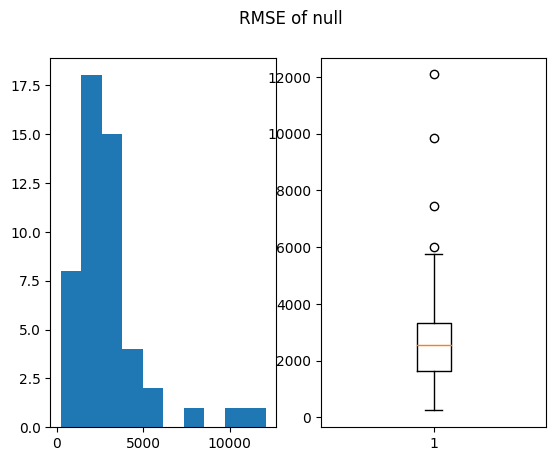

<Figure size 640x480 with 0 Axes>

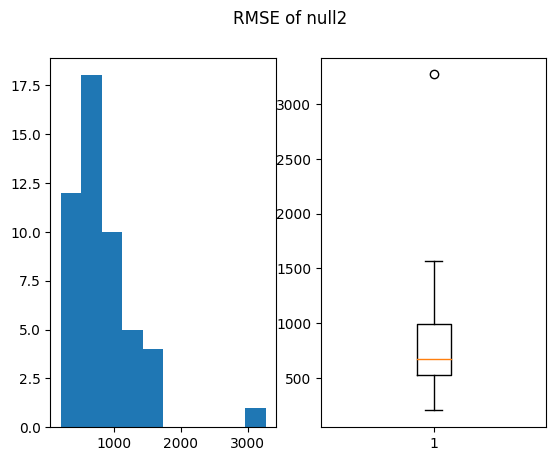

<Figure size 640x480 with 0 Axes>

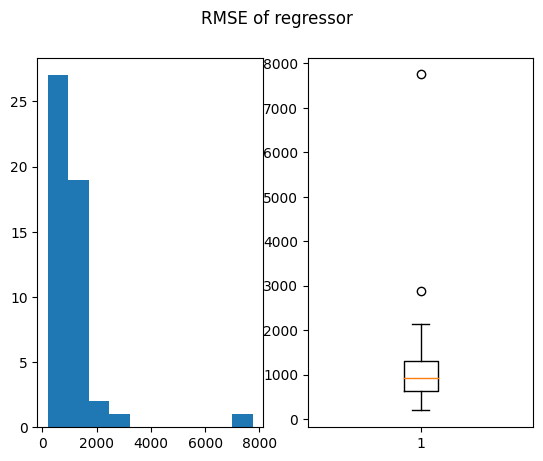

<Figure size 640x480 with 0 Axes>

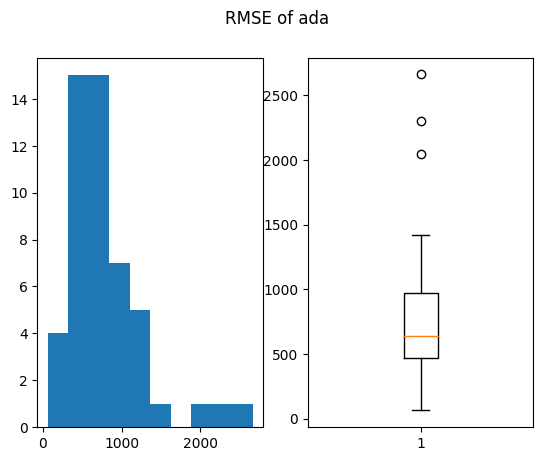

<Figure size 640x480 with 0 Axes>

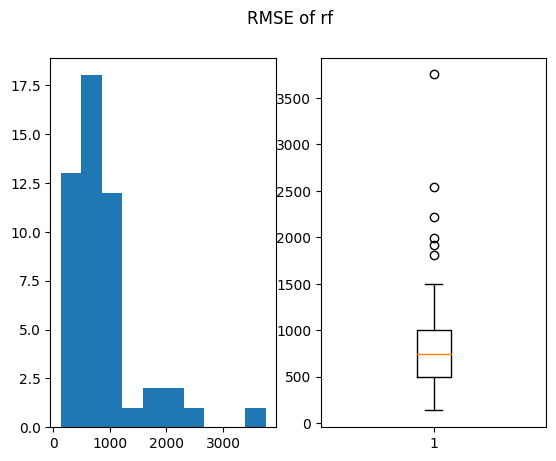

<Figure size 640x480 with 0 Axes>

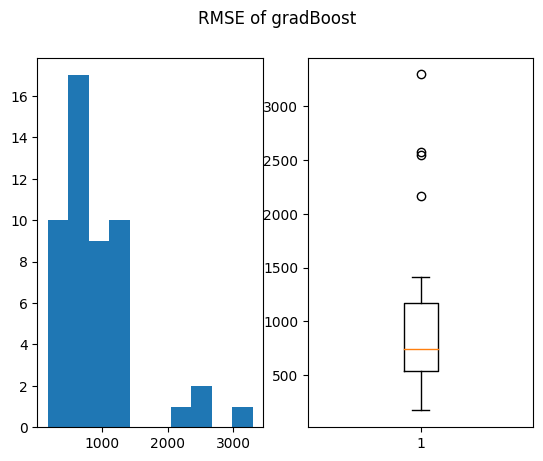

<Figure size 640x480 with 0 Axes>

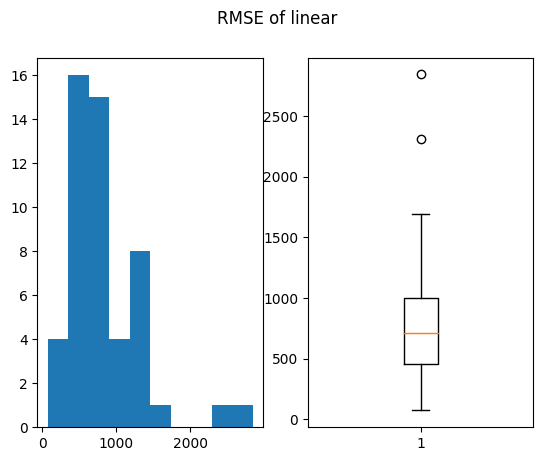

In [233]:
# K-fold, since the above is pretty random
from sklearn.model_selection import KFold

# Change to 50 for actual evaluation
# n = 50
n = 50

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": [],
    "null2": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    getPCA(X_train, X_test)

    y_null_predict = [y_train.mean()] * len(X_test)

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)
    mses["null"].append(mse_null)

    modelTest = modelData.loc[X_test.index]
    mse_null_2 = mean_squared_error(modelTest["Rate per 100,000 population"], modelTest["Last Offence Rate"])
    mses["null2"].append(mse_null_2)
    
    

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(models["regressor"], feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())

for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()
    

FEATURE 2: Pick the top 20 highest NMI score features only

In [234]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Since most attribute uses the default discretiser, 
# this function will help with the NMI calculation
def getNMI(att1: np.array, att2: np.array, n_bins=5):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    # Avoid the removal of bin by normalizing the data
    norm_att1 = (att1 - att1.min())/ (att1.max() - att1.min()) * 100
    norm_att2 = (att2 - att2.min())/ (att2.max() - att2.min()) * 100

    discrete_att1 = discretizer.fit_transform(norm_att1.reshape(-1, 1)).astype(int)
    discrete_att2 = discretizer.fit_transform(norm_att2.reshape(-1, 1)).astype(int)
    return normalized_mutual_info_score(discrete_att1.flatten(), discrete_att2.flatten())

def getTopNMICommunities(X_train, y_train):
    allScores = []
    for column in communities.columns:
        if column not in X_train.columns:
            continue
        score = getNMI(np.array(X_train[column]), np.array(y_train))
        allScores.append((column, score))
    allScores.sort(key=lambda x: -x[1])
    return [col[0] for col in allScores][:20]

C:\Users\DELL\AppData\Local\Temp\ipykernel_24512\2472727201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["pca"] = features_pca.transform(X_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_24512\2472727201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the nu

MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 687015.5763979295
RMSE of regressor : 828.8199248744409
MSE of ada : 345211.10021193756
RMSE of ada : 587.5434376201954
MSE of rf : 549651.2250462435
RMSE of rf : 741.3667120304194
MSE of gradBoost : 530883.5605228033
RMSE of gradBoost : 728.4829348116281
MSE of linear : 502379.2913162628
RMSE of linear : 708.7871938301332
Used attributes for regressor tree: 
Last Offence Rate                                    1320
Public Housing Dwellings                              124
IRSD (avg)                                            116
pca                                                   116
Homelessness                                           90
Last Housing Price                                     80
Presentations to emergency departments, 2012-13        76
Last EGM                                               74
Unpaid carer of childr

<Figure size 640x480 with 0 Axes>

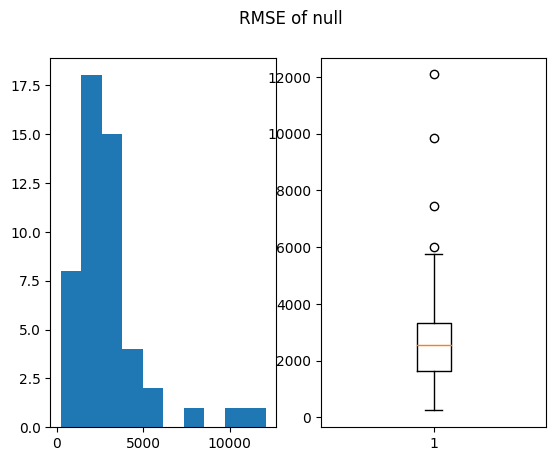

<Figure size 640x480 with 0 Axes>

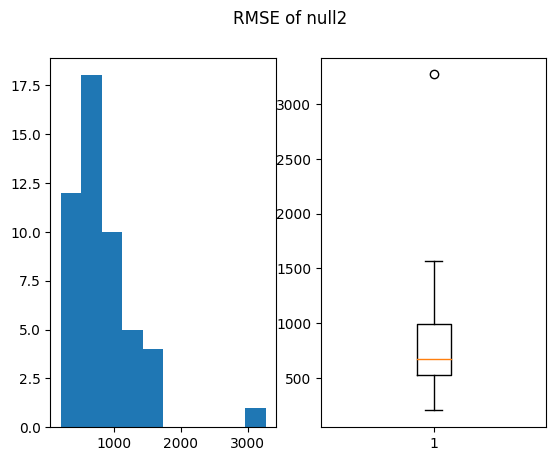

<Figure size 640x480 with 0 Axes>

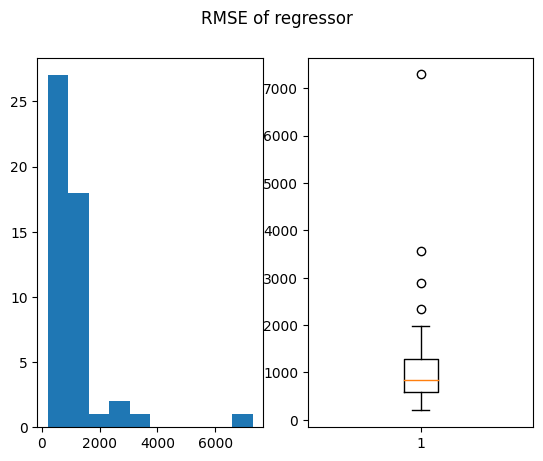

<Figure size 640x480 with 0 Axes>

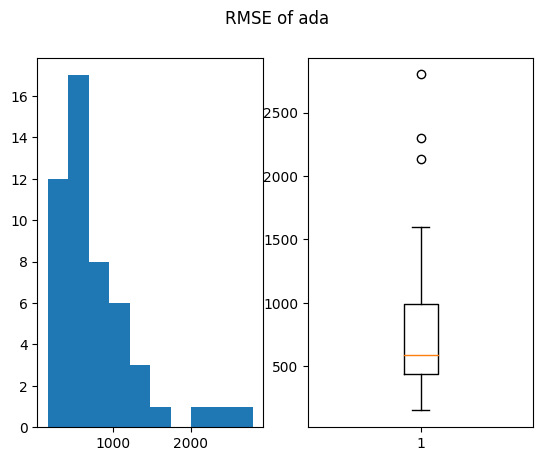

<Figure size 640x480 with 0 Axes>

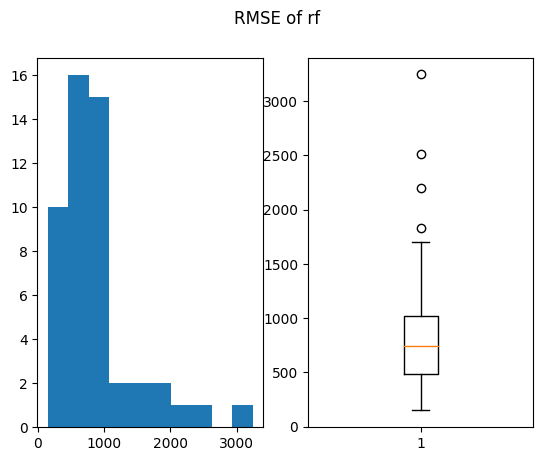

<Figure size 640x480 with 0 Axes>

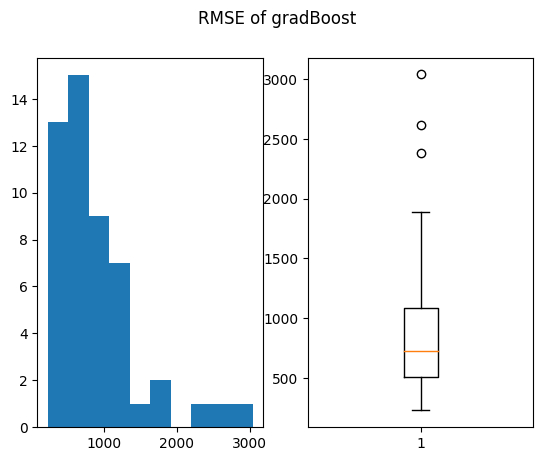

<Figure size 640x480 with 0 Axes>

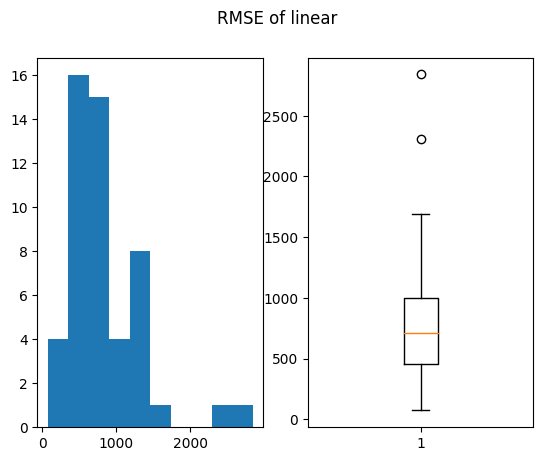

In [235]:
# Try restricting the input to only the top 10 highest NMI attribute from communities
from sklearn.model_selection import KFold

n = 50

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": [],
    "null2": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    getPCA(X_train, X_test)

    top20Communities = getTopNMICommunities(X_train, y_train)
    dropCol = []
    for column in communities.columns:
        if column in X.columns and column not in top20Communities:
            dropCol.append(column)

    X_train = X_train.drop(columns=dropCol)
    X_test = X_test.drop(columns=dropCol)

    y_null_predict = [y_train.mean()] * len(X_test)

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)
    mses["null"].append(mse_null)

    modelTest = modelData.loc[X_test.index]
    mse_null_2 = mean_squared_error(modelTest["Rate per 100,000 population"], modelTest["Last Offence Rate"])
    mses["null2"].append(mse_null_2)

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(models["regressor"], feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())



for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()


    